<a href="https://colab.research.google.com/github/majavier26/App_Physics_157/blob/master/Term%20deposit%20prediction/Term_deposit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
! pip install shap
! pip install xgboost
! pip install lightgbm

In [348]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as cm

# Modelling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# Data balancing
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

# Interpretation
import shap
from sklearn.cluster import KMeans

# Miscellaneous
import time

In [72]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Term deposit prediction

[This dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) comes from UC Irvine Machine Learning Repository and it involves classifying if a client will avail a term deposit from a handful of input variables. We have 16 input variables:
- age (numeric)
- job (categorical)
- marital status (categorical)
- education (categorical)
- default history (binary)
- average yearly balance (binary)
- existence of housing loan (binary)
- contact communication type (categorical)
- last contact day of the month (numeric)
- last contact month of the year (categorical)
- last contact duration (numeric)
- number of contacts performed (numeric)
- days that passed after client was last contacted in this campaign (numeric)
- previous number of contacts before this campaign
- outcome of previous marketing campaign

and one output variable: whether a client has availed a term deposit.

### Exploratory data analysis

#### Preliminary checking
Let's import the dataset.

In [73]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Term deposit availing prediction/Data/bank-full.csv', sep=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Although the website says that there are no null values, let's still check it for good measure.

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Now let's see the relevant statistical metrics for this dataset. We already know that the dataset contains 4521 rows and it indeed does, shown in the `count` row.

We also see in the `age column` that the minimum age is 19 years old, barely pass the legal age, and that the maximum age is 87 years old. It must be noted that the opposite sides of the age spectrum is correlated with risky behavior.

We also see the opposite behaviors in the `balance` column where the minimum balance is -€3313 while the maximum balance is +€4521.

In [75]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Observing the data

Now that our data is initialized, we can observe the relationships of the variables with each other. We can closely observe how some variables can correlate with the occurence of clients availing a term deposit. Let's make a function that will plot a distribution of clients if they availed a term deposit or not.

In [221]:
def plot_numgraph(data, var1, var2, title):
  # Uses DataFrame data to plot a histogram showing the distribution of clients according to string var2 and is segregated via string var1 and entitles it with a string title.
  # Stats
  mean_var, std_var = data[var1].groupby(data[var2]).mean().loc['yes'], data[var1].groupby(data[var2]).std().loc['yes']
  sigma_low, sigma_high = mean_var - std_var, mean_var + std_var

  # Plotting
  sns.histplot(data=data, x=var1, hue=var2, multiple='stack', palette='Set2')
  plt.title(title)
  plt.xticks(rotation=30, fontsize=10)
  plt.axvline(x=mean_var, ymin=0, ymax=470, color='red', linestyle='--')
  plt.fill_between([sigma_low, sigma_high], 0, 500, alpha=0.4, color='gray')
  if data[var1].max() > 10000:
    plt.xlim([sigma_low, 10000])
  # Annotation
  plt.text(x=mean_var, y=450, s=f'Mean {var1}\n{np.round(mean_var, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
  plt.text(x=sigma_low, y=450, s=f'{np.round(sigma_low, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round', alpha=0.6))
  plt.text(x=sigma_high, y=450, s=f'{np.round(sigma_high, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round', alpha=0.6))
  plt.show()
  return None

In [189]:
def plot_catgraph(data, var1, title):
  # Uses DataFrame data to plot a histogram showing the distribution of clients according to string var 1 and entitles it with a string title.

  # Plotting
  sns.histplot(data=data, x=var1, hue='y', multiple='stack', palette='Set2')
  if var1 == 'job':
    plt.xticks(rotation=90, fontsize=10)
  else:
    plt.xticks(rotation=30, fontsize=10)
  if var1 == 'campaign':
    plt.xlim([0, 10])
  plt.title(title)
  plt.show()

  return None

##### **Client details vs. Y**

Here, we will observe how details of the client affect if they avail a term deposit.

###### **Age**
The distribution is right-skewed as middle-aged people are generally the largest clientele of banks. We can also see a sharp drop in counts when `age > 60` as the retirement age is either 60 or 65 year old.

We can observe that age range is 19-87 and mean age of the people who availed a term deposit is 42.5 with a standard deviation of ~18. Using the 68-95-99 rule, we can say that 65% of the people who availed a term deposit are within ~29 to ~56 years old. This is our target population and we want to capitalize on them, so we must employ techniques that will cater to them.

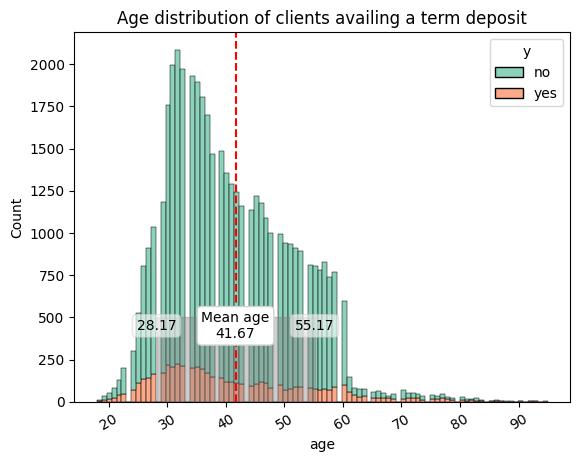

In [222]:
plot_numgraph(data, 'age', 'y', 'Age distribution of clients availing a term deposit')

###### **Employment**

To see what jobs are more inclined to avail a term deposit, we can do the same thing but with the `job` column. Below we see that the top 5 employment of term deposit-availing clients are:
- management
- self-employed
- blue-collar
- admin.
- retired

This make sense as the pay grade of these people are within or above the average. However, this does not mean that we should only cater our services to them as we figured out previously that we should cater to middle class people.

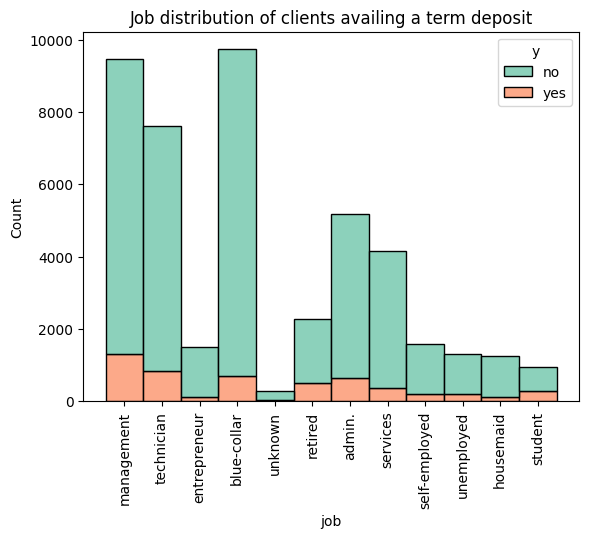

In [224]:
plot_catgraph(data, 'job', 'Job distribution of clients availing a term deposit')

###### **Balance**

Here we see a very skewed distribution, with most of the clients having close to 0 balance by the end of the year. However, we see that the mean balance is €1571 with a 1-sigma range of -€877 and 4016. We see that our target audience are middle class people, preferrably with positive balance.

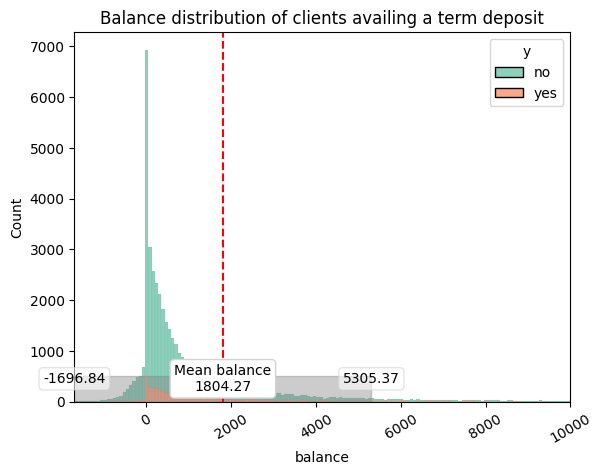

In [223]:
plot_numgraph(data, 'balance', 'y', 'Balance distribution of clients availing a term deposit')

###### **Existing housing loan**

The relation between an existing house loan and term deposit availment is shown in the first subplot. For the clients with an existing housing loan, out of the people who availed a term deposit, we can see that there were 3354 people who doesn't have a housing loan and 1935 people that has a housing loan (about 1/3). However, we can see clearly that the people who didn't avail a deposit were more likely the ones who has a housing loan.

This can be explained by seeing the relation of balance left at the end of the year and housing. On the second subplot, we can see that there were slightly more people with a housing loan whose balance is less than 1000 than the people who doesn't. This is the likely reason for the fact that thee were more people who doesn't have a housing loan that availed a term deposit, because they still have money left to avail it. For the people who **has** an existing loan, they may now think that their leftover balance will grow if left in a term deposit and may even help them pay off the housing loan in the future.

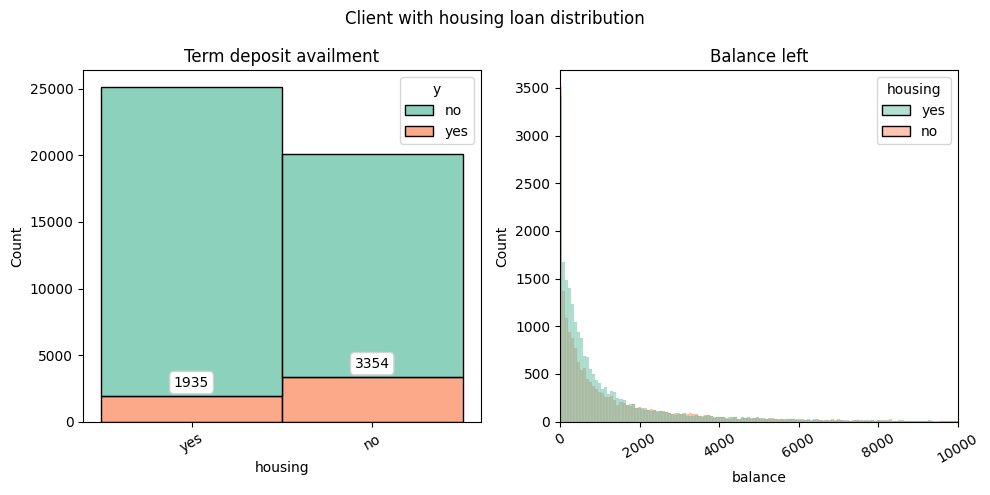

In [239]:
# Initialization
plt.figure(figsize=(10, 5))
plt.suptitle('Client with housing loan distribution')

# Loan vs. Y subplot
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='housing', hue='y', multiple='stack', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
## Annotation
count_housing_yes, count_housing_no = data['housing'].groupby(data['y']).value_counts().loc['yes', 'yes'], data['housing'].groupby(data['y']).value_counts().loc['yes', 'no']
plt.text(x=0, y=count_housing_yes + 1000, s=f'{np.round(count_housing_yes, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.text(x=1, y=count_housing_no + 1000, s=f'{np.round(count_housing_no, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.title('Term deposit availment')

# Balance vs. loan subplot
plt.subplot(1, 2, 2)
sns.histplot(data=data, x='balance', hue='housing', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
plt.xlim([0, 10000])
plt.title('Balance left')

plt.tight_layout()
plt.show()

###### **Existing loan**

With a general loan, we see the same behavior with that of housing loan. One thing of note though is about 91% of the people who availed a term deposit do not have a loan, as again, these might be people who have leftover balance so they can avail a deposit.

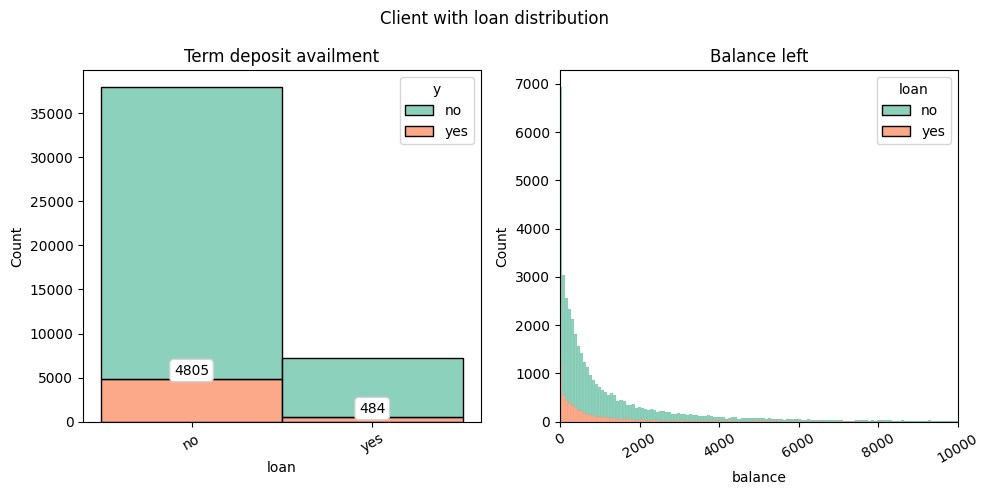

In [240]:
# Initialization
plt.figure(figsize=(10, 5))
plt.suptitle('Client with loan distribution')

# Loan vs. Y subplot
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='loan', hue='y', multiple='stack', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
## Annotation
count_loan_yes, count_loan_no = data['loan'].groupby(data['y']).value_counts().loc['yes', 'yes'], data['loan'].groupby(data['y']).value_counts().loc['yes', 'no']
plt.text(x=1, y=count_loan_yes + 1000, s=f'{np.round(count_loan_yes, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.text(x=0, y=count_loan_no + 1000, s=f'{np.round(count_loan_no, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.title('Term deposit availment')
plt.title('Term deposit availment')

# Balance vs. loan subplot
plt.subplot(1, 2, 2)
sns.histplot(data=data, x='balance', hue='loan', multiple='stack', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
plt.xlim([0, 10000])
plt.title('Balance left')


plt.tight_layout()
plt.show()

##### **Campaign details vs. Y**

We will now see how the campaign of the telesales agent affect client's probability of availing a term deposit.

###### **Campaign duration and amount**

**Campaign duration**

Now, we can observe how the duration of campaign and amount of contacts made to the client in the previous campaign. Looking first at the first subplot, the mean contact duration of clients who didn't avail is ~221 seconds or ~3.68 minutes while the maximum is at ~2 minutes. For the clients who availed a term deposit, the mean duration is ~537 seconds or ~8.95 seconds and maximum is at ~6 minutes.

We can then say that there is a correlation with the contact duration and term deposit availment as it seems that the shorter the duration is, the more likely the client will not avail, and the opposite is true. This makes sense as the clients who are not interested in the product will want to get on with their day and drop the call immediately.

This then highlights the importanceof a skilled telesales agent, as they are responsible for persuading clients to invest in a term deposit. A top-performing agent can successfully secure a client's commitment within the first six minutes of a call, demonstrating their exceptional ability to influence and engage.

**Campaign amount**

We can see that the maximum amount of clients who availed has been contacted once. This is probably because they have already been contacted before and has availed already. The number of clients being contacted also decreases quickly with the amount of tries while the amount of clients who didn't avail tho is not decreasing as fast.

This is probably due to the sales agent is maximizing the amount of tries it can do to a client and minimizing the probability of non-availment. If the telesales agent calls the client too much, the client might get annoyed and see the company as a nuisance which will negatively impact their availment probability.


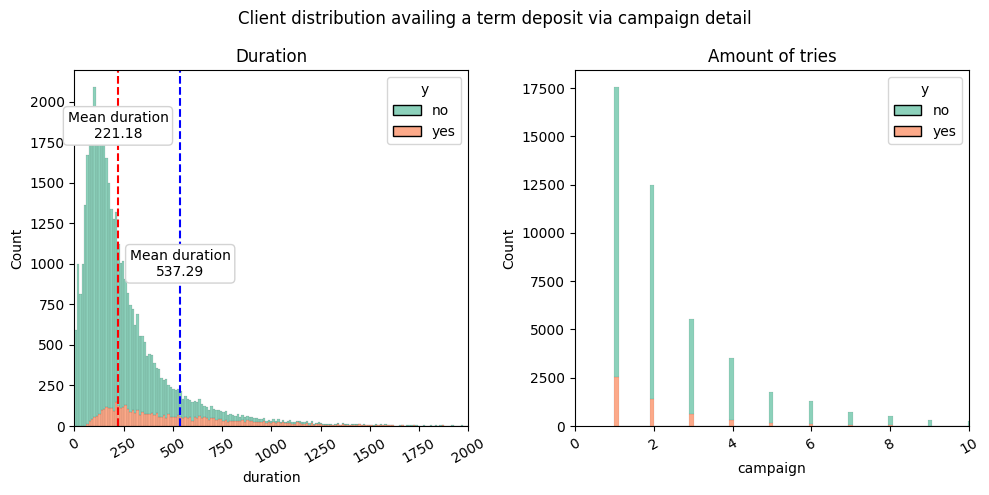

In [218]:
plt.figure(figsize=(10, 5))
plt.suptitle('Client distribution availing a term deposit via campaign detail')

# Campaign duration subplot
plt.subplot(1, 2, 1)
## Plotting
sns.histplot(data=data, x='duration', hue='y', multiple='stack', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
plt.xlim([0, 2000])
## Annotation
mean_duration_yes, std_duration_yes = data['duration'].groupby(data['y']).mean().loc['yes'], data['duration'].groupby(data['y']).std().loc['yes']
mean_duration_no, std_duration_no = data['duration'].groupby(data['y']).mean().loc['no'], data['duration'].groupby(data['y']).std().loc['no']
plt.axvline(x=mean_duration_no, color='red', linestyle='--')
plt.axvline(x=mean_duration_yes, color='blue', linestyle='--')
plt.text(x=mean_duration_yes, y=1000, s=f'Mean duration\n{np.round(mean_duration_yes, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.text(x=mean_duration_no, y=1850, s=f'Mean duration\n{np.round(mean_duration_no, 2)}',
         horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
plt.title('Duration')

# Campaign type subplot
plt.subplot(1, 2, 2)
sns.histplot(data=data, x='campaign', hue='y', multiple='stack', palette='Set2')
plt.xticks(rotation=30, fontsize=10)
plt.xlim([0, 10])
plt.title('Amount of tries')

plt.tight_layout()
plt.show()

###### **Contact type**

For the contact type, the majority of the clients were contacted using a mobile phone, and thye least is a telephone. This is probably due to the ubiquity of cellphones, making them have the largest share of clients. It may help if there were more agents assigned to contact via cellphone than telephones.

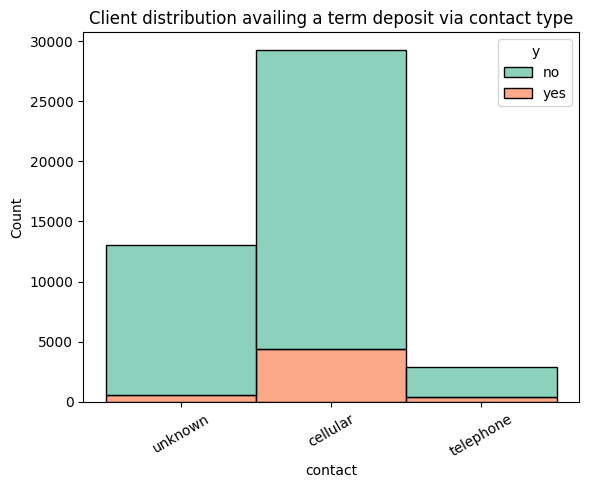

In [193]:
plot_catgraph(data, 'contact', 'Client distribution availing a term deposit via contact type')

###### **Outcome of previous campaign**

Now, we can observe whether clients who availed a loan

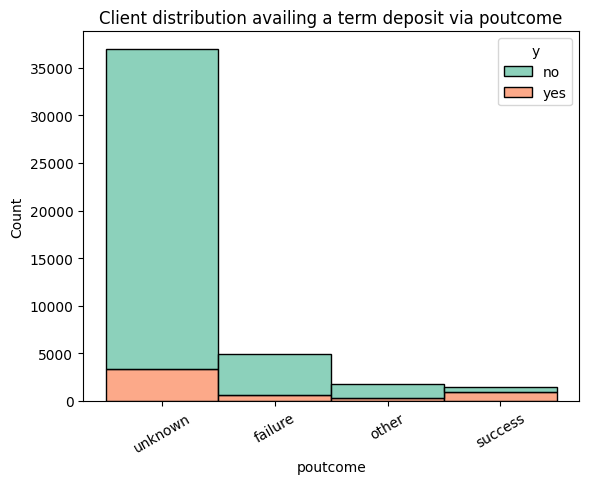

In [195]:
plot_catgraph(data, 'poutcome', 'Client distribution availing a term deposit via poutcome')

###### **Contact month**

This now tells you what month the client was last contacted. We can see that the most clients were contacted was in May while the least was in December. This relatively high volume of contacts made started in Apr, boomed in May until Aug, then it dwindled at the start of the "ber" months. The availed term deposit volume also increased from Apr-Aug. This high volume also increased  significantly in Nov, then dying out in Dec.

This is probably due to the capitalization of sales agents on the "bonus" season, as Apr-May is usually when performance bonuses are given to the employees. The months after that might be the period of convincing clients to deposit their remaining bonus salary for it to inflate in the future.

The relative increase in Novemeber on the other hand might be due to people preparing for the holiday season. The minimum length of a term deposit is one month, thus a person can deposit some money in November and collect it next month to be spent on Christmas day.

The low volume in Dec-Jan might be explained by the holiday season too, as December is peak spending season, while Jan is the recovery period from spending, thus their low volumes.

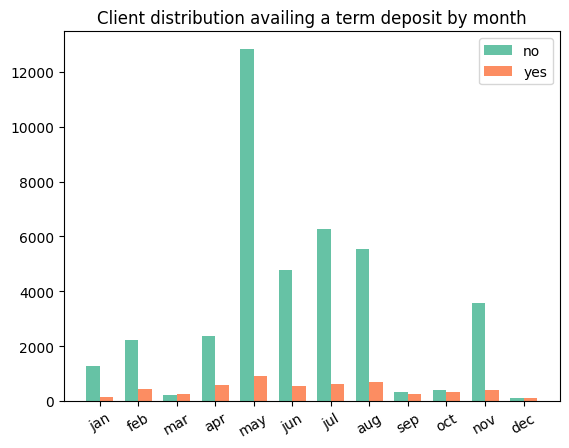

In [277]:
# Counting y grouped by months
month_count_no, month_count_yes = data['month'].groupby(data['y']).value_counts().loc['no'], data['month'].groupby(data['y']).value_counts().loc['yes']

# Ordering the counts
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_order = {month: i for i, month in enumerate(month_names)}
month_count_no, month_count_yes = month_count_no.sort_index(key=lambda x: x.map(month_order)), month_count_yes.sort_index(key=lambda x: x.map(month_order))

# Plotting
x, dx = np.arange(len(month_names)), 0.35
plt.bar(x - dx/2, month_count_no, dx, label='no', color=cm.rgb2hex(sns.color_palette("Set2")[0]))
plt.bar(x + dx/2, month_count_yes, dx, label='yes', color=cm.rgb2hex(sns.color_palette("Set2")[1]))
plt.legend()
plt.xticks(x, month_names, rotation=30, fontsize=10)
plt.title('Client distribution availing a term deposit by month')
plt.show()

### Preprocessing data

#### Encoding categorical data
Since our data contains categorical and binary variables, we have to convert them into numerical ones so that our ML models could understand them. We have the choice of converting our variables between one-hot encoding and label encoding, however we will choose the former as our variables are not in order (except `month`).

In [84]:
data_target = data['y']
data_features = data.iloc[:, :-1]

In [85]:
num_features = data_features.select_dtypes(include=np.number)
cat_features = data_features.select_dtypes(include=object)

##### **Target**

Let's focus on the target first since that is easy. Our target `y` is just a boolean, so we can convert it easily with a dictionary.

In [86]:
data_target_new = data_target.map({'no':0, 'yes':1})

##### **Numerical features**

From the summary earlier, the `balance` column has a lot of range while the other columns does not possess that same range. This will result in `balance` influencing the algorithm more as it has bigger values. What we should do is to standardize the data so that every feature has equal weight.

In [87]:
scaler = MinMaxScaler()
num_features_new = pd.DataFrame(scaler.fit_transform(num_features), columns=num_features.columns)
num_features_new

,age,balance,day,duration,campaign,pdays,previous
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000


##### **Categorical features**

For the categorical features, we may want to use `data_features.select_dtypes(include=object)` for ease of use, and well yes, but it doesn't aid us when we interpret it. The way the aforementioned code works is it takes all of the unique values in an array, and assign values to all of the unique values.

For the "true" categorical features such as `job`, the labels can be arbitrary, but for the boolean columns and `month`, it can prove to give unexpected results. The value `no` can be labeled as `1` and vice-versa. For `month`, since there is an established order for months, it would help that the months are labeled ordinally.

That is why we will separate the categorical columns into three:
- "true" categories: `job`, `marital`, `education`, `education`, `contact`, `poutcome`
- boolean: `default`, `housing`, `loan`
- ordinal: `month`

In [88]:
cat_features = data_features[['job', 'marital', 'education', 'contact', 'poutcome']]
bool_features = data_features[['default', 'housing', 'loan']]
ordinal_features = data_features['month']

For cat_features, we can encode them using `LabelEncoder()` from `sklearn.preprocessing`.

In [89]:
cat_columns = cat_features.columns
label_encoder = LabelEncoder()
cat_encoded_list = [label_encoder.fit_transform(cat_features[col]) for col in cat_columns]
cat_encoded_df = pd.DataFrame({cat_columns[idx]:cat_encoded_list[idx] for idx, col in enumerate(cat_columns)})
cat_encoded_df

,job,marital,education,contact,poutcome
0,4,1,2,2,3
1,9,2,1,2,3
2,2,1,1,2,3
3,1,1,3,2,3
4,11,2,3,2,3
...,...,...,...,...,...
45206,9,1,2,0,3
45207,5,0,0,0,3
45208,5,1,1,0,2
45209,1,1,1,1,3


For `bool_features`, we can reuse what we did on `data_target`

In [90]:
bool_columns = bool_features.columns
bool_encoded_list = [bool_features[col].map({'no':0, 'yes':1}) for col in bool_columns]
bool_encoded_df = pd.DataFrame({bool_columns[idx]:bool_encoded_list[idx] for idx, col in enumerate(bool_columns)})
bool_encoded_df

,default,housing,loan
0,0,1,0
1,0,1,0
2,0,1,1
3,0,1,0
4,0,0,0
...,...,...,...
45206,0,0,0
45207,0,0,0
45208,0,0,0
45209,0,0,0


Now, we can do the same method for `month` by using a dictionary, but using the function `to_datetime` from Pandas is much easier. Since the months are not spelled out, we must use `format='%b'` as an argument in the function.

In [91]:
month_df = pd.to_datetime(data['month'], format='%b').dt.month
month_df

,month
0,5
1,5
2,5
3,5
4,5
...,...
45206,11
45207,11
45208,11
45209,11


Then, we can concatenate the numerical features `num_features_new` and all of the encoded categorical features `cat_encoded_df`.

In [92]:
data_features_new = pd.concat([num_features_new, cat_encoded_df, bool_encoded_df, month_df], axis=1)
data_features_new

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,contact,poutcome,default,housing,loan,month
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,4,1,2,2,3,0,1,0,5
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,9,2,1,2,3,0,1,0,5
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,2,1,1,2,3,0,1,1,5
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,1,1,3,2,3,0,1,0,5
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,11,2,3,2,3,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,9,1,2,0,3,0,0,0,11
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,5,0,0,0,3,0,0,0,11
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,5,1,1,0,2,0,0,0,11
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,1,1,1,1,3,0,0,0,11


### Feature selection

Now that we have concatenated the numerical and categorical features, we can move on to feature selection. This will ensure that the confounding variables are eliminated, all of the variables are relevant, and no overfitting will occur.

#### Feature correlation

We see if some features are correlated with each other, so that we can remove confounding variables.

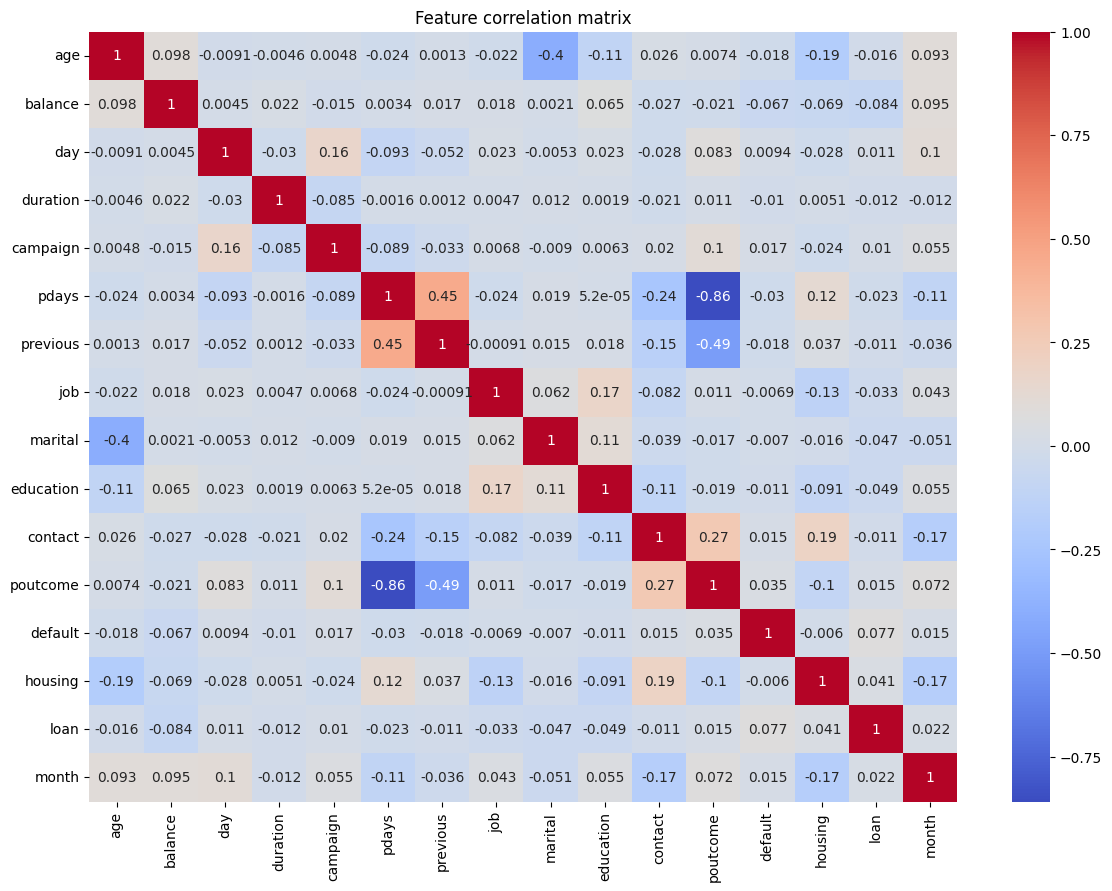

In [93]:
# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
plt.title('Feature correlation matrix')
sns.heatmap(data_features_new.corr(), annot=True, cmap='coolwarm')
plt.show()

What we are looking for here is medium to strong correlation between each feature. Immediately, we three variable pairs that satisfy this:
- `previous` v. `pdays`: 0.58 (medium positive correlation)
- `poutcome` v. `pdays`: -0.86 (strong negative correlation)
- `poutcome` v. `previous`: -0.64 (medium negative correlation)

We also see a slight positive correlation with `age` and `marital` and it makes sense because older people are more likely to be maried than young adults. Going back, it makes sense that there is this correlation between `previous`, `pdays`, and `poutcome` as they are all controlled by the contact of telesales/sales agent to the customer. We will then remove the features `previous` and `pdays` and retain `poutcome` in the data as I think that the outcome of the campaign will much better predict the possibility of the client availing a term deposit, and not some day interval between campaigns.

Let's look at the correlation matrix again after dropping these two columns.

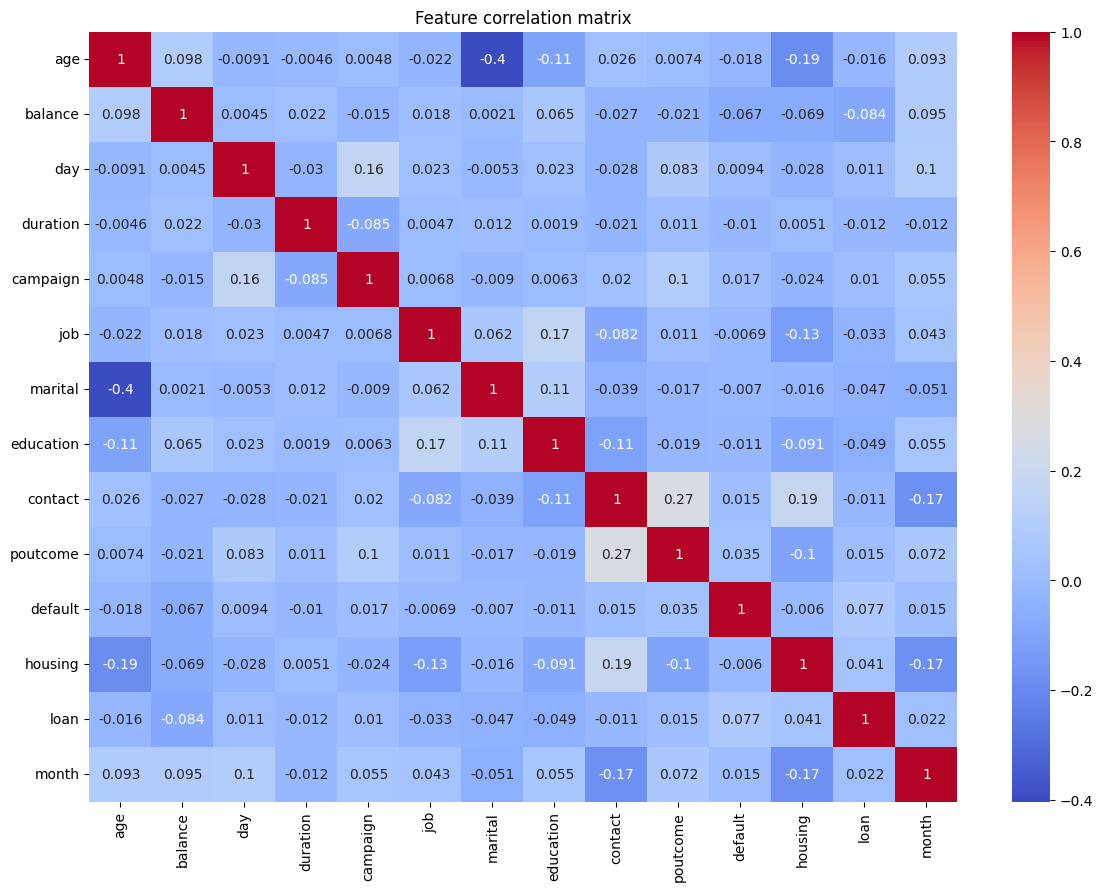

In [94]:
# Dropping previous and pdays columns
data_features_drop = data_features_new.drop(['previous', 'pdays'], axis=1)

# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
plt.title('Feature correlation matrix')
sns.heatmap(data_features_drop.corr(), annot=True, cmap='coolwarm')
plt.show()

Let's examine the shapes of our features and target to see if they have the same length.

In [95]:
print(f'Target shape: {data_target_new.shape}, Features shape: {data_features_new.shape}')

Target shape: (45211,), Features shape: (45211, 16)


Now, we must split our data with the usual train-test-val split (60:20:20).

In [295]:
# Splitting data with 70:30 first
x_train, x_test, y_train, y_test = train_test_split(data_features_drop, data_target_new, test_size = 0.2, random_state=26)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=26) # 0.25 x 0.8 = 0.2

In [296]:
print(f'Train target shape: {y_train.shape}, Train features shape: {x_train.shape}')
print(f'Validation target shape: {y_val.shape}, Validation features shape: {x_val.shape}')
print(f'Test target shape: {y_test.shape}, Test features shape: {x_test.shape}')

Train target shape: (27126,), Train features shape: (27126, 14)
Validation target shape: (9042,), Validation features shape: (9042, 14)
Test target shape: (9043,), Test features shape: (9043, 14)


### Sampling and modeling the data

Since our data features moderate imbalance, as only 13% of the clients surveyed availed a term deposit in both `bank.csv` and `bank-full.csv`, we should either do undersampling, oversampling, or a combination of both. We will also use multiple ML models and rank them via their precision and recall rather than accuracy due to the imbalance in our data.

Lastly, the models that we will use are:
- LogisticRegressor
- RandomForestClassifier
- DecisionTreeClassifier
- GradientBoostingClassifier
- AdaBoostClassifier
- ExtraTreesClassifier
- XGBoostClassifier
- LightGBMClassifier


#### Sampling the data

As aforementioned, we will use various techniques to address the imbalance in our dataset. We will have our un-imputed data as control, oversampling, undersampling, and combined resampling methods.

##### **ML Metrics**

But before that, we will make a function first that will automatically use our ML models and outputs the relevant results: precision, recall, F1 score, and AUC. **Precision** is the percentage of positive predictions that were correct while **recall** is the percentage of actual positive instances that the model identified successfully [1]. **F1 score** is basically a combination of the two as it is determined by taking the harmonic mean of the two. Meanwhile, **AUC** or area under the curve represents the probability that the model will rank the positive higher than the negative if given a positive and negative example [2].

In [297]:
def run_models(x_train, x_val, y_train, y_val, model_dict):
  # Runs a model from model_dict that takes in aalready split data.
  # It outputs a dataframe that contains the precision, recall, f1, auc and runtime of the model.

  # Metrics
  train_scores, val_scores = [], []
  train_precision, val_precision = [], []
  train_recall, val_recall = [], []
  train_f1, val_f1 = [], []
  train_auc, val_auc = [], []
  time_runs = []

  # Preprocessing
  for model_name, model in model_dict.items():
    # Starting stopwatch
    time_start = time.time()

    # Fitting and predicting
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)

    # Logging the metrics
    ## Accuracy
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    ## Precision
    train_precision.append(precision_score(y_train, train_pred))
    val_precision.append(precision_score(y_val, val_pred))
    ## Recall
    train_recall.append(recall_score(y_train, train_pred))
    val_recall.append(recall_score(y_val, val_pred))
    ## F1 score
    train_f1.append(f1_score(y_train, train_pred))
    val_f1.append(f1_score(y_val, val_pred))
    ## AUC
    train_auc.append(roc_auc_score(y_train, train_pred))
    val_auc.append(roc_auc_score(y_val, val_pred))

    # Ending stopwatch
    time_end = time.time()
    time_run = time_end - time_start
    time_runs.append(time_run)

  # Collating results
  result_df = pd.DataFrame(
      {'Model': list(models_dict.keys()),
       'Train accuracy': train_scores, 'Validation accuracy': val_scores,
       'Train precision': train_precision, 'Validation precision': val_precision,
       'Train recall': train_recall, 'Validation recall': val_recall,
       'Train F1': train_f1, 'Validation F1': val_f1,
       'Train AUC': train_auc, 'Validation AUC': val_auc,
       'Runtime': time_runs
       }
  )
  return result_df

In [99]:
models_dict = {
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=26, max_features=None),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=26),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=26),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=26),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=26),
    'XGBoostClassifier': XGBClassifier(random_state=26, use_label_encoder=False, eval_metric='logloss'),
    'LightGBMClassifier': lgb.LGBMClassifier(random_state=26, verbosity=-1)
}

##### **Control sample**

The control sample will use the computed train, validation, and test split earlier. Now, we can finally run all of these models on our control data.

In [ ]:
results_control = run_models(x_train, x_val, y_train, y_val, models_dict)

In [451]:
results_control

,Model,Train accuracy,Validation accuracy,Train precision,Validation precision,Train recall,Validation recall,Train F1,Validation F1,Train AUC,Validation AUC,Runtime
0,LogisticRegressor,0.889368,0.889184,0.593684,0.600000,0.177414,0.180113,0.273190,0.277056,0.580648,0.582032,0.275921
1,RandomForestClassifier,1.000000,0.900243,1.000000,0.594907,1.000000,0.482176,1.000000,0.532642,1.000000,0.719147,18.566343
2,DecisionTreeClassifier,1.000000,0.873811,1.000000,0.466548,1.000000,0.490619,1.000000,0.478281,1.000000,0.707822,0.228281
3,GradientBoostingClassifier,0.910602,0.901792,0.695539,0.633234,0.421831,0.396811,0.525162,0.487889,0.698659,0.683047,4.607474
4,AdaBoostClassifier,0.894714,0.893608,0.601001,0.590278,0.302296,0.318949,0.402260,0.414129,0.637827,0.644680,1.813777
5,ExtraTreesClassifier,1.000000,0.901349,1.000000,0.655914,1.000000,0.343340,1.000000,0.450739,1.000000,0.659634,4.291599
6,XGBoostClassifier,0.964757,0.904446,0.907292,0.617991,0.778861,0.496248,0.838186,0.550468,0.884148,0.727625,0.568605
7,LightGBMClassifier,0.936518,0.905994,0.794581,0.631068,0.618119,0.487805,0.695329,0.550265,0.798453,0.724845,0.928317


To easily visualize the precision and recall scores for most of the models, we can plot the results below. We will not conside the `accuracy` scores as that doesn't punish the the model for making wrong predictions.

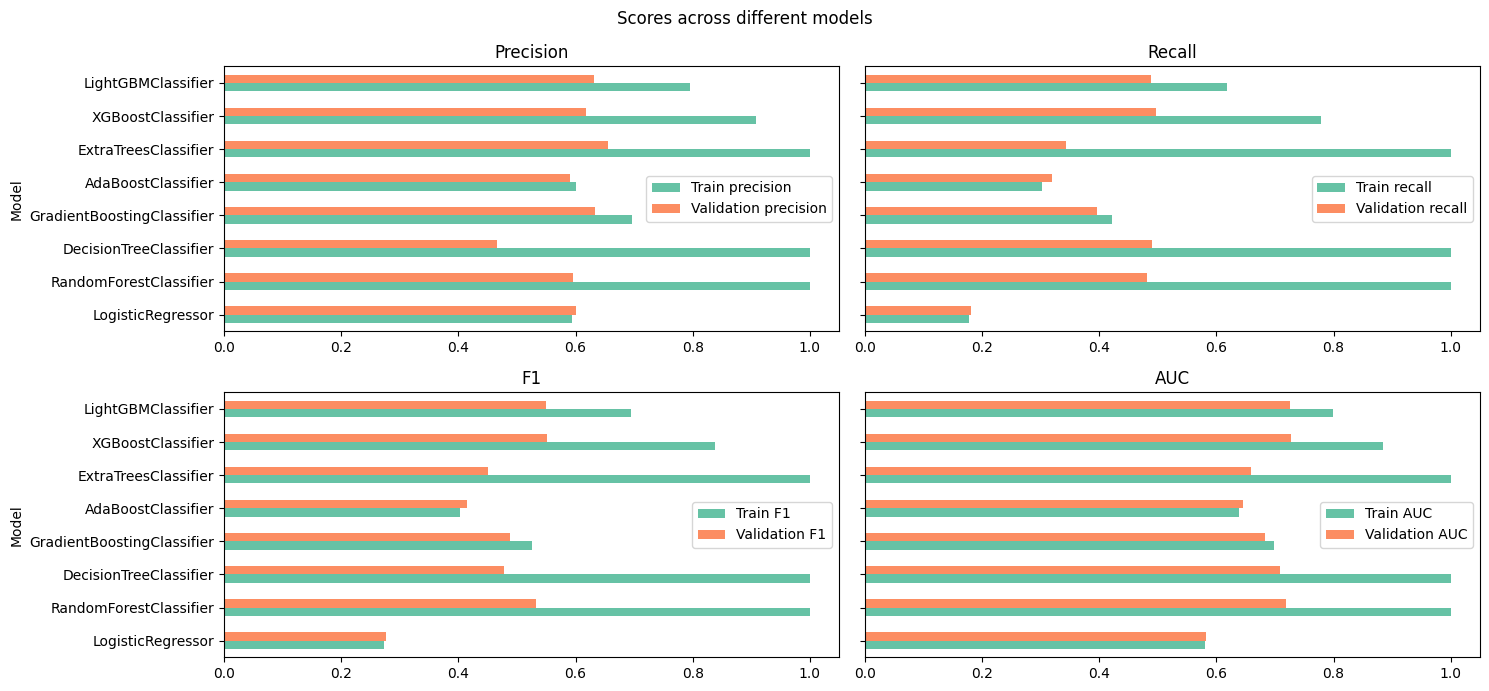

In [299]:
metrics_pair = np.array(results_control.columns[3:-1]).reshape((4, 2))
titles = ['Precision', 'Recall', 'F1', 'AUC']
colors = sns.color_palette("Set2", as_cmap=True)(np.linspace(0, 1, 6))

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
plt.suptitle('Scores across different models')
for idx, pair in enumerate(metrics_pair):
  # Reshape data for horizontal plotting
  plot_data_control = results_control[np.concatenate((['Model'], pair), axis=0)]
  plot_data_control = plot_data_control.set_index('Model')

  # Create horizontal bar chart
  i, j = idx // 2, idx % 2
  ax = axes[i, j]
  ax.set_xlabel('Score')
  ax.set_title(f'{titles[idx]}')
  plot_data_control.plot(ax=ax, kind='barh', color=colors)

  # Remove ylabels except 1st subplot
  if idx == 1 or idx == 3:
        ax.set_yticklabels([])
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

As we can see above, we can see that the scores in training always perform better than that in validation as the model hasn't seen the data in validation yet. We can also observe that SVC is a terrible model as it produced 0% recall and precision while having ~88% accuracy. This is another example why we cannot trust accuracy as a metric.

The top 3 performing models for each validation score are as follows:
- Precision: GradientBoosting > ExtraTrees > LightGBM
- Recall: DecisionTree > XGB > LightGBM
- F1 score: XGB > LightGBM > RandomForest
- AUC score: LightGBM > XGB > RFC

We can see that LightGBM made the cut for top 3 in all of the scores while XGB made it in the latter 3 (as XGB was only top 4 in precision). By this demonstration we can see then that **F1 score is the score that we need to watch out for** in every model as it manages to balance out precision, recall, and AUC.

##### **Undersampling**

Now, we will consider undersampling. Since our data contains 5289 rows with `y` values as `yes`, this algorithm will also cut the rows with `no` as a `y` value to 5289.

In [300]:
undersampling_dict = {'RandomUnderSampler': RandomUnderSampler(random_state=26),
                      'TomekLinks': TomekLinks(),
                      'NearMiss': NearMiss(),
                      'AllKNN': AllKNN(),
                      'ENN': EditedNearestNeighbours(),
                      'RepeatedENN': RepeatedEditedNearestNeighbours()}

Then, we can reiterate each undersampling method to the our data and run each of our models with them.

In [ ]:
results_undersampler = []

# Running run_models on each undersampler
for sampler_name, sampler in undersampling_dict.items():
  x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
  x_val_resampled, y_val_resampled = sampler.fit_resample(x_val, y_val)
  results_undersampler.append(run_models(x_train_resampled, x_val_resampled, y_train_resampled, y_val_resampled, models_dict))

Collating the F1 score data for each model we get:

In [302]:
# Initialize the dataframe that will house F1 scores across different models and undersamplers
results_f1_undersample = pd.DataFrame({'Model': models_dict.keys(), 'Control':results_control['Validation F1']})

# Plotting
dict_undersample = {}
for idx, result in enumerate(results_undersampler):
  dict_temp = {list(undersampling_dict.keys())[idx]: result['Validation F1']}
  dict_undersample.update(dict_temp)

results_f1_undersample = pd.concat([results_f1_undersample, pd.DataFrame(dict_undersample)], axis=1)
results_f1_undersample

,Model,Control,RandomUnderSampler,TomekLinks,NearMiss,AllKNN,ENN,RepeatedENN
0,LogisticRegressor,0.277056,0.788811,0.308772,0.802360,0.445583,0.431423,0.454837
1,RandomForestClassifier,0.532642,0.851122,0.576577,0.890120,0.706994,0.694827,0.723926
2,DecisionTreeClassifier,0.478281,0.780861,0.530926,0.851263,0.610261,0.597015,0.631196
3,GradientBoostingClassifier,0.487889,0.858056,0.538843,0.899531,0.680916,0.653608,0.692580
4,AdaBoostClassifier,0.414129,0.802601,0.415536,0.845781,0.550054,0.532475,0.577754
5,ExtraTreesClassifier,0.450739,0.832258,0.501771,0.899587,0.673532,0.647028,0.683153
6,XGBoostClassifier,0.550468,0.859368,0.591633,0.903981,0.724953,0.713076,0.737595
7,LightGBMClassifier,0.550265,0.862385,0.596386,0.908665,0.729008,0.721797,0.753817


From the dataframe above, we can see that the best performing model is the **LightGBMClassifier with NearMiss** sampling method with an F1 socre of **0.908665**. However, the second best performing model should be given flowers, XGBoost with NearMiss, as their F1 scores are equal up to two decimal places as it had an F1 score of 0.903981.

These results are great, as the higher the F1 score is, the better the model is. However, this high of an F1-score may mean overfitting. This means that we should still check the test data later to confirm overfitting.

To better see the differences between each of the models and sampling methods, we can plot them to visualize.

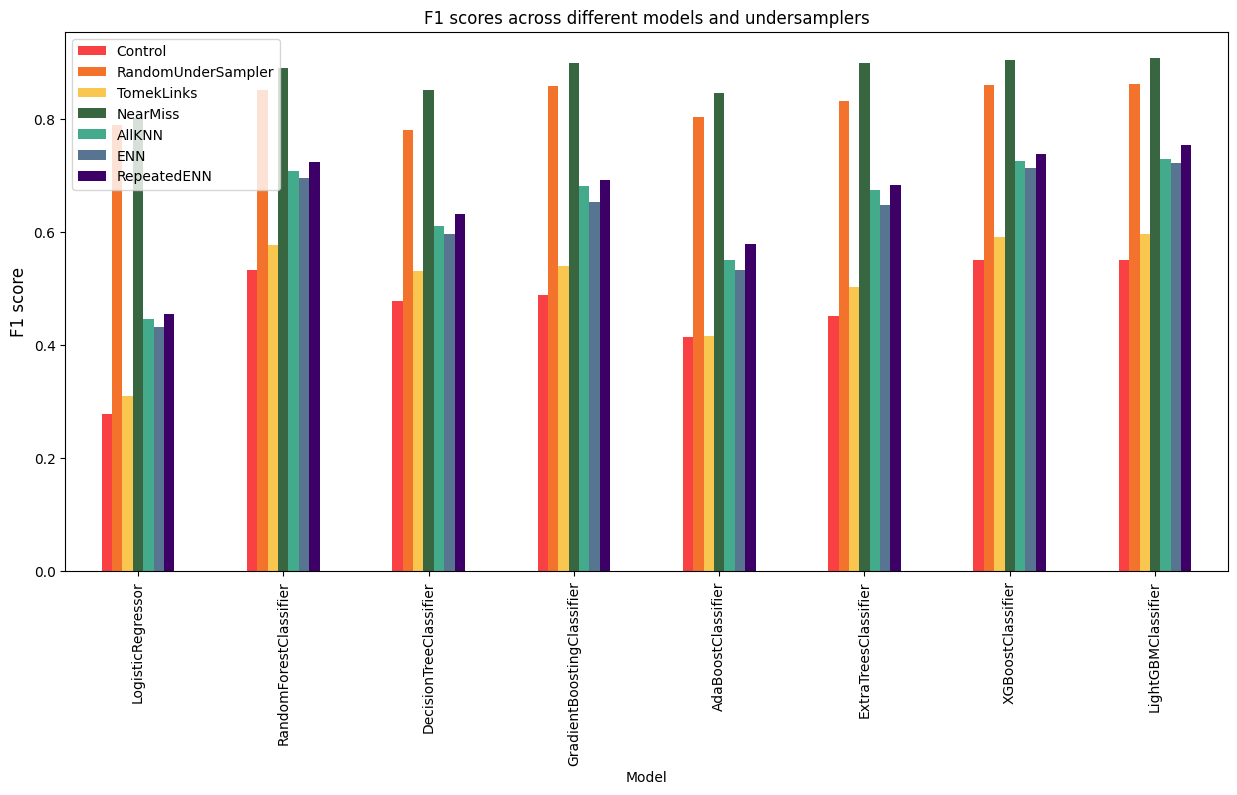

In [303]:
colors_new = ['#f94144', '#f3722c', '#f9c74f', '#386641', '#43aa8b', '#577590', '#3d0066']
cmap_new = cm.LinearSegmentedColormap.from_list("cmap_undersample", colors_new)
model_names = list(models_dict.keys())

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('F1 scores across different models and undersamplers')
ax.set_ylabel('F1 score', fontsize = 12)
results_f1_undersample.plot(ax=ax, kind='bar', color=colors_new)
ax.set_xticklabels(model_names, rotation=90, fontsize=10)
ax.set_xlabel('Model')
plt.show()

##### **Oversampling and combined methods**

For oversampling, the algorithm will try to inflate the minority group by either duplicating the minority or creating new minority values by interpolation. These are `RandomOverSampler`, `SMOTE`, `ADASYN`, and `BorderlineSMOTE`.
Combined methods is, exactly what you think, combining undersampling and oversampling methods.


In [304]:
oversampling_dict = {'RandomOverSampler': RandomOverSampler(random_state=26),
                    'SMOTE': SMOTE(random_state=26),
                    'ADASYN': ADASYN(random_state=26),
                    'BorderlineSMOTE': BorderlineSMOTE(random_state=26),
                    'SMOTEENN': SMOTEENN(random_state=26),
                    'SMOTETomek': SMOTETomek(random_state=26)}

Reiterating each model and sampling method:

In [305]:
results_oversampler = []

# Running run_models on each undersampler
for sampler_name, sampler in oversampling_dict.items():
  x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
  x_val_resampled, y_val_resampled = sampler.fit_resample(x_val, y_val)
  results_oversampler.append(run_models(x_train_resampled, x_val_resampled, y_train_resampled, y_val_resampled, models_dict))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:36:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

Looking at the F1 scores collection, we can see that the best performing model-sample combo is **XGBoost and SMOTEENN with a score of 0.959191** with the runner-up being LightGBMClassifier and SMOTEENN with a score of 0.956691, equal to the champion by 3 decimal places. Again, these scores may be too high though, so we should check these models again later for overfitting.

In [306]:
# Initialize the dataframe that will house F1 scores across different models and undersamplers
results_f1_oversample = pd.DataFrame({'Model': models_dict.keys(), 'Control':results_control['Validation F1']})

# Plotting
dict_oversample = {}
for idx, result in enumerate(results_oversampler):
  dict_temp = {list(oversampling_dict.keys())[idx]: result['Validation F1']}
  dict_oversample.update(dict_temp)

results_f1_oversample = pd.concat([results_f1_oversample, pd.DataFrame(dict_oversample)], axis=1)
results_f1_oversample

,Model,Control,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SMOTEENN,SMOTETomek
0,LogisticRegressor,0.277056,0.792948,0.839826,0.834422,0.846425,0.875847,0.842398
1,RandomForestClassifier,0.532642,0.700572,0.883195,0.881645,0.889683,0.920150,0.884414
2,DecisionTreeClassifier,0.478281,0.577722,0.833737,0.834458,0.839518,0.886963,0.836941
3,GradientBoostingClassifier,0.487889,0.854574,0.907348,0.901118,0.911648,0.937429,0.909306
4,AdaBoostClassifier,0.414129,0.812764,0.862432,0.854627,0.868326,0.902469,0.865973
5,ExtraTreesClassifier,0.450739,0.454787,0.850742,0.849012,0.855907,0.901203,0.856551
6,XGBoostClassifier,0.550468,0.825114,0.932168,0.931308,0.933409,0.959191,0.933672
7,LightGBMClassifier,0.550265,0.860656,0.932620,0.926798,0.935202,0.956691,0.935121


In [309]:
results_f1_oversample.max()

,0
Model,XGBoostClassifier
Control,0.550468
RandomOverSampler,0.860656
SMOTE,0.93262
ADASYN,0.931308
BorderlineSMOTE,0.935202
SMOTEENN,0.959191
SMOTETomek,0.935121


Let's visualize these models and the oversampling methods for good measure.

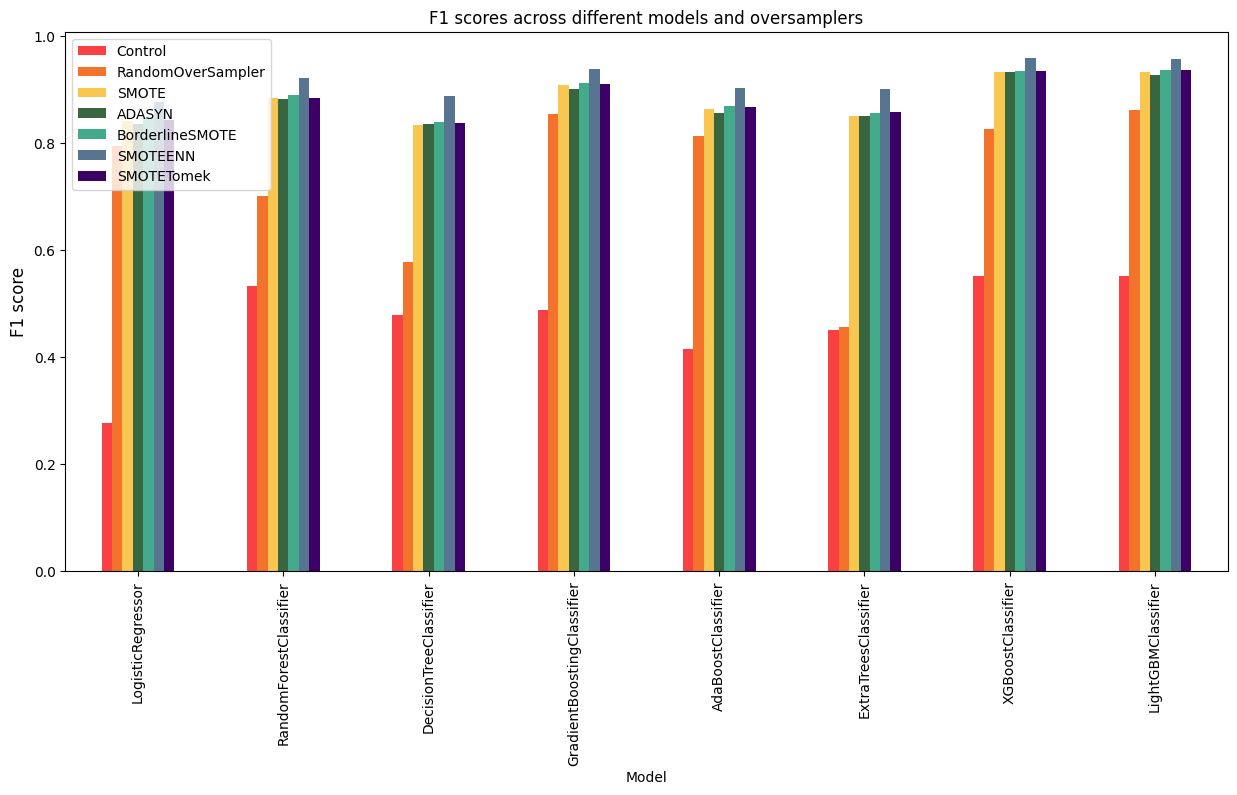

In [307]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('F1 scores across different models and oversamplers')
ax.set_ylabel('F1 score', fontsize = 12)

# Plotting
results_f1_oversample.plot(ax=ax, kind='bar', color=colors_new)
ax.set_xticklabels(model_names, rotation=90, fontsize=10)
ax.set_xlabel('Model')
plt.show()

#### Hyperparameter tuning

Hyperparameter tuning is the process of iterating over set values and passing it as parameters to a selected machine learning model and picking the set of parameters that will give the highest score. In our case, we will choose the parameters that gives the highest F1 score. To lessen computation time, we will use `GridSearchCV` instead of `RandomizedSearchCV`.

##### **LightGBMClassifier and NearMiss sampling**

This is the best performing model when we're doing undersampling. For the hyperparameters that we will tune, we will use what the [LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) say that `num_leaves`, `min_data_in_leaf`, and `max_depth` are the parameters that most impact the model. From that, we will choose these parameters for our tuning:
- `num_leaves`: 10, 20, 35, 50
- `min_data_in_leaf`: 100, 200, 500, 1000
- `max_depth`: 2, 3, 5, 7

Now we can make another training and validation set for AllKNN sampling and set up the parameter grid.

In [310]:
# Sampling the data using NearMiss
x_train_lgb, y_train_lgb = NearMiss().fit_resample(x_train, y_train)
x_val_lgb, y_val_lgb = NearMiss().fit_resample(x_val, y_val)

# Setup the parameter grid
param_grid_lgb = {
    'num_leaves': [10, 20, 35, 50],
    'min_data_in_leaf': [100, 200, 500, 1000],
    'max_depth': [2, 3, 5, 7]
}

After setting the parameter grid, we can now use `GridSearchCV` and look for the parameters that will give the best `f1` score.

In [312]:
lgbm = lgb.LGBMClassifier(random_state=26)
grid_search_lgb = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgb, scoring='f1', cv=3, verbose=10, return_train_score=True)
grid_search_lgb.fit(x_train_lgb, y_train_lgb)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START max_depth=2, min_data_in_leaf=100, num_leaves=10...........
[CV 1/3; 1/64] END max_depth=2, min_data_in_leaf=100, num_leaves=10;, score=(train=0.894, test=0.863) total time=   0.2s
[CV 2/3; 1/64] START max_depth=2, min_data_in_leaf=100, num_leaves=10...........
[CV 2/3; 1/64] END max_depth=2, min_data_in_leaf=100, num_leaves=10;, score=(train=0.882, test=0.868) total time=   0.2s
[CV 3/3; 1/64] START max_depth=2, min_data_in_leaf=100, num_leaves=10...........
[CV 3/3; 1/64] END max_depth=2, min_data_in_leaf=100, num_leaves=10;, score=(train=0.881, test=0.872) total time=   0.2s
[CV 1/3; 2/64] START max_depth=2, min_data_in_leaf=100, num_leaves=20...........
[CV 1/3; 2/64] END max_depth=2, min_data_in_leaf=100, num_leaves=20;, score=(train=0.894, test=0.863) total time=   0.2s
[CV 2/3; 2/64] START max_depth=2, min_data_in_leaf=100, num_leaves=20...........
[CV 2/3; 2/64] END max_depth=2, min_data_in_leaf=

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=26),
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_data_in_leaf': [100, 200, 500, 1000],
                         'num_leaves': [10, 20, 35, 50]},
             return_train_score=True, scoring='f1', verbose=10)

Below, we can see that the best parameters are:
- `max_depth` = 5
- `min_data_in_leaf` = 100
- `num_leaves` = 35

In [314]:
grid_search_lgb.best_params_, grid_search_lgb.best_estimator_

({'max_depth': 5, 'min_data_in_leaf': 100, 'num_leaves': 35},
 LGBMClassifier(max_depth=5, min_data_in_leaf=100, num_leaves=35,
                random_state=26))

Then we can fit and predict with the model again

In [315]:
final_lgb = lgb.LGBMClassifier(max_depth=5, min_data_in_leaf=100, num_leaves=35, random_state=26)
final_lgb.fit(x_train_lgb, y_train_lgb)

train_pred_lgb = final_lgb.predict(x_train_lgb)
val_pred_lgb = final_lgb.predict(x_val_lgb)
val_f1_lgb = f1_score(y_val_lgb, val_pred_lgb)

And we can see that we get an `F1 score` of 0.91! We will check for overfitting later.

In [316]:
print(f'Validation set F1 score: {val_f1_lgb:.2f}')

Validation set F1 score: 0.91


##### **XGBoost and SMOTEENN sampling**

This is best performing model and sampling method when doing oversampling/combined methods. For the hyperparameters that we'll tune, we will use the guidance of [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html) and use `max_depth`, `min_child_weight`, `gamma`, and `subsample` to make the model more robust to noise. We will also use `learning_rate` and the numbers from [this site](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python) to survey from these parameters:
- `max_depth`: 2, 3, 5, 7
- `min_child_weight`: 1, 3, 5, 7
- `gamma`: $x/10, x\in [0, 4]$
- `learning_rate`: 0.1, 0.01, 0.001
- `subsample`: 0.5, 0.7, 1

Now we can make another training and validation set for SMOTEENN sampling and set up the parameter grid.

In [317]:
# Sampling the data using SMOTEENN
x_train_xgb, y_train_xgb = SMOTEENN().fit_resample(x_train, y_train)
x_val_xgb, y_val_xgb = SMOTEENN(random_state=26).fit_resample(x_val, y_val)

# Setting up the parameter grid
param_grid_xgb = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i/10.0 for i in range(0,5)], # really small values
    'subsample': [0.5, 0.7, 1]
}

Just like earlier,we can now use `GridSearchCV` and look for the parameters that will give the best `f1` score after setting the parameter grid.

In [319]:
xgb = XGBClassifier(random_state=26)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, scoring='f1', verbose=10, return_train_score=True)
grid_search_xgb.fit(x_train_xgb, y_train_xgb)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 1/3; 1/240] START gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5.
[CV 1/3; 1/240] END gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5;, score=(train=0.960, test=0.925) total time=   0.6s
[CV 2/3; 1/240] START gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5.
[CV 2/3; 1/240] END gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5;, score=(train=0.949, test=0.956) total time=   1.1s
[CV 3/3; 1/240] START gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5.
[CV 3/3; 1/240] END gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.5;, score=(train=0.948, test=0.955) total time=   0.6s
[CV 1/3; 2/240] START gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.7.
[CV 1/3; 2/240] END gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.7;, score=(train=0.960, test=0.923) total time=   0.2s
[CV 2/3; 2/240] START gamma=0.0, max_depth=2, min_child_weight=1, subsample=0.7.
[CV 2/3;

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=26, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [2, 3, 5, 7],
                         'min_child_weight': [1, 3, 5, 7],
                         'subsample': [0.5, 0.7, 1]},
             return_train_score=True, scoring='f1', verbose=10)

In [320]:
grid_search_xgb.best_params_, grid_search_xgb.best_estimator_

({'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7},
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.0, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=26, ...))

Below, we can see that the best parameters:
- `gamma`: 0.2
- `learning_rate`: 0.1
- `max_depth`: 7
- `min_child_weight`: 1
- `subsample`: 0.7

In [322]:
final_xgb = XGBClassifier(gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, subsample=0.7)
final_xgb.fit(x_train_xgb, y_train_xgb)

train_pred_xgb = final_xgb.predict(x_train_xgb)
val_pred_xgb = final_xgb.predict(x_val_xgb)
val_f1_xgb = f1_score(y_val_xgb, val_pred_xgb)

And below we can see that the computed F1 score is 0.95 which looks really good but also smells fishy since the value is really close to 1. Normally, we would want that but we might have also gotten this high of a number if we have overfitted the model.

In [323]:
print(f'Validation set F1 score: {val_f1_xgb:.2f}')

Validation set F1 score: 0.95


Moving forward, we will still choose both and see if the models really have overfitted.

### Model interpretation

After using the validation data, we can now see if our models really have overfitted by using the test data, data that the model has never seen before.

#### LightGBMClassifier and Nearmiss sampling

We can now use our test data that the models have not seen at all. We will see how the model performs with it.

In [324]:
# Combining the train and validation data to fit for test data, and resampling test data
x_test_lgb, y_test_lgb = AllKNN().fit_resample(x_test, y_test)

# Model fitting and prediction
final_lgb.fit(x_train_lgb, y_train_lgb)
test_pred_lgb = final_lgb.predict(x_test_lgb)
test_f1_lgb = f1_score(y_test_lgb, test_pred_lgb)

In [325]:
print(f'Test set F1 score: {test_f1_lgb:.2f}')

Test set F1 score: 0.50


This model performed badly with an F1 score of 0.48, which tells us that the LGBM classifier really has overfitted the data. Perhaps we can add more parameters in the hyperparameter tuning section to reduce overfitting.

This model will be left alone for now.

####  XGBoost and SMOTEENN sampling

We can now use our test data that the models have not seen at all. We will see how the model performs with it.

In [330]:
# Combining the train and validation data to fit for test data, and resampling test data
x_test_xgb, y_test_xgb = SMOTEENN(random_state=26).fit_resample(x_test, y_test)

# Model fitting and prediction
final_xgb.fit(x_train_xgb, y_train_xgb)
test_pred_xgb = final_lgb.predict(x_test_xgb)
test_f1_xgb = f1_score(y_test_xgb, test_pred_xgb)

In [346]:
np.unique(test_pred_xgb)

array([0, 1])

We see that the F1 score is 0.87, which is promising since this is the test data! This model has not overfitted over our data.

In [331]:
print(f'Test set F1 score: {test_f1_xgb:.2f}')

Test set F1 score: 0.87


##### **Feature importance**

We can observe how each feature is important by calling the `model.feature_importance_`.

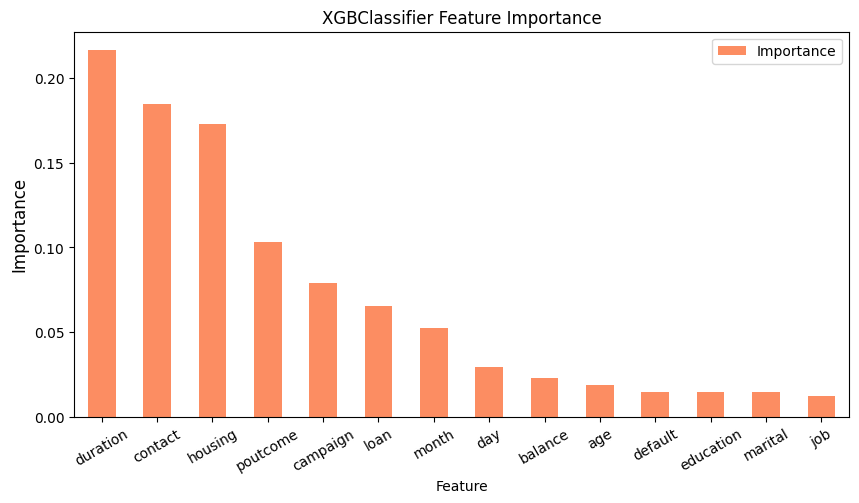

In [332]:
# Determining feature importance
xgb_importance = final_xgb.feature_importances_
data_features_drop_columns = data_features_drop.columns
xgb_importance_df = pd.DataFrame({'Feature': data_features_drop_columns, 'Importance': xgb_importance})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('XGBClassifier Feature Importance')
ax.set_ylabel('Importance', fontsize = 12)

# Plotting
xgb_importance_df.plot(ax=ax, kind='bar', color=cm.rgb2hex(sns.color_palette("Set2")[1]))
ax.set_xticklabels(xgb_importance_df['Feature'], rotation=30, fontsize=10)
ax.set_xlabel('Feature')
plt.show()

From the graph below, we can see that the top 7 features that affect if the client will avail a term deposit is:
- Duration: This variable denotes how long the last campaign contact is. It really shows the importance of a good telesales agent as the decision of the client in the first 1-2 minutes highly correlates with them availing the deposit. As we saw in the EDA section, majority of the clients didn't avail a deposit in the first 1-2 minutes.
- Contact: This variable denotes how the client was contacted: cellphone, telephone, or unknown. We saw that the highest volume of clients who availed a deposit was contacted via phone.
- Housing or general loan: The existence of any kind of loan affects the deposit availment as people are more likely to avail it if they don't have an existing loan.
- Poutcome:
- Campaign: This denotes the amount of tries an agent has contacted the client during this campaign. Most of availing clients has only been contacted once, meaning they availed already. The number of availing clients decreases as the number of tries increases, probably due to client annoyance, indifference, or incapacity. The contacted volume also decreases as the number of tries increases as the company can't keep spending resources trying to convince an unwilling client.
- Month: This is the month where the client has been contacted. Contact volume increases during peak seasons: bonus season and foreholiday, as the telesales agents are probably capitalizing on this season. This helps as the amount of availing clients also increase during these seasons. "Dry" season such as Dec-Jan also sees the decrease of contact volume, as it is the end and start of the year.

#####  SHAP values
[SHAP values](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/) or (Shapley Additive Explanations) is a method based on game theory and is mainly used for easier interpretation of machine learning models. We will use this method to provide more context to the results of our model.

In [333]:
explainer_xgb = shap.Explainer(final_xgb)
shapval_xgb = explainer_xgb(x_test_xgb)

In [334]:
shapval_xgb.shape

(13191, 14)

`shapval_xgb` is an Explanation object with shape $100\times16$ because we passed in the first 100 rows of `x_train_lgb`. We can use a waterfall plot to try to explain how each variable was taken into account in the model, how impactful they are and how they influence the prediction of the class of a datapoint.

Below, we have the waterfall plot of the first sample, and how the variables

In [ ]:
shapval_lgb[0]

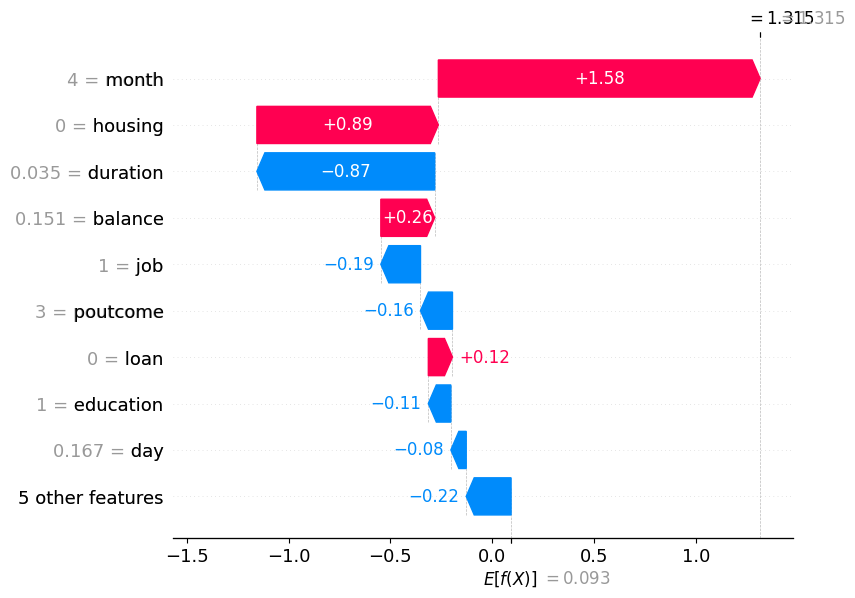

In [335]:
shap.plots.waterfall(shapval_xgb[0])

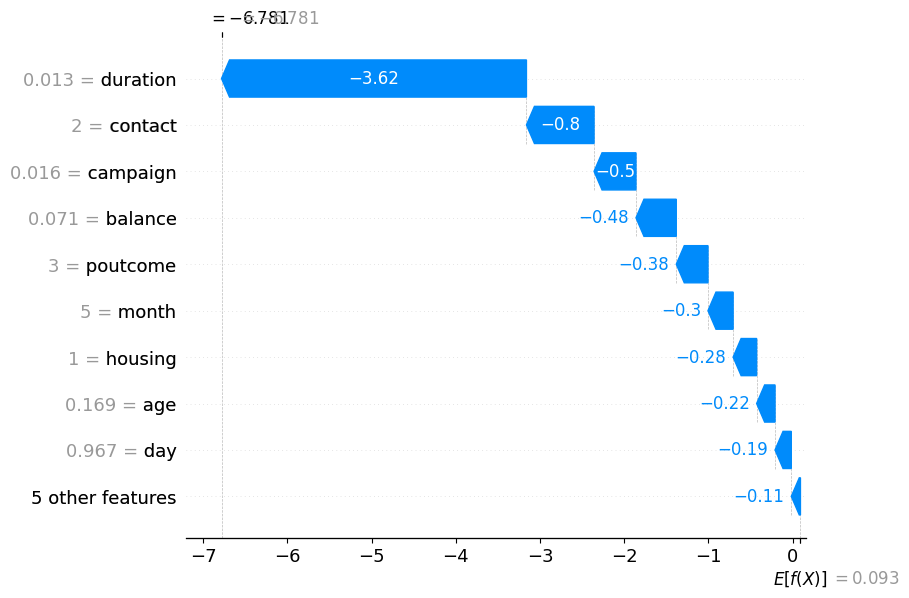

In [336]:
shap.plots.waterfall(shapval_xgb[5])

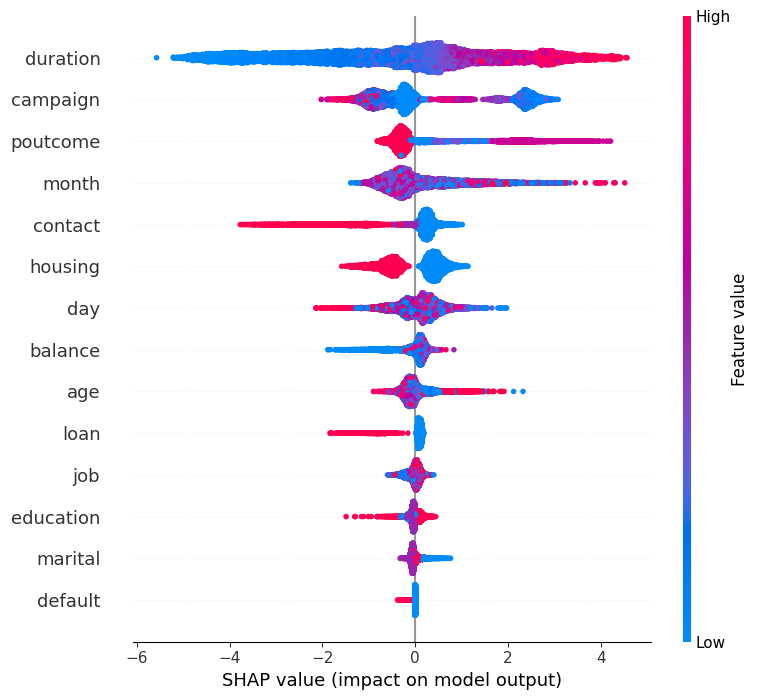

In [347]:
shap.summary_plot(shapval_xgb, x_test_xgb, plot_type='dot', show=False)
plt.tight_layout()
plt.show()

### Suggestions and Policy

**Telesales agent**

Importance of a good telesales agent, employ yung sinasabi ni mark na commission system, the better agents get rewarded while the worse agents are fucked

best pair model. Basically, if likely mangutang si client, they assign them to top performers

Do more mobile contact campaign, mag-campaign din through ads sa cellphone to further capitalize

Wag masyado kulitin si client

**Client details**

If may existing loan, maybe 'wag nang tawagan

I-capitalize yung peak seasons: April-May dahil sa bonus, Holiday season

### Further analyses



#### Client type determination

Let's see if we can identify potential clients by k-means clustering. [K-means clustering](https://www.w3schools.com/python/python_ml_k-means.asp) is a type of unsupervised learning method that measures the distance of each datapoint from each other. $k$ amount of centroids are computed and datapoints are assigned to their closes centroid.

To determine how many clients we should use, we will use an elbow plot and essentially identify its "elbow". We can make a function that makes an elbow plot for us.

In [349]:
def optimize_clusters(data, max_cluster):
  # Takes in a DataFrame/array data and integer max_cluster and performs k-means clustering on it.
  # Plots an elbow plot of the inertia and returns None.

  means, inertias = [], []

  for n in range(1, max_cluster):
    kmeans = KMeans(n_clusters=n, random_state=26)
    kmeans.fit(data)

    # Append means and inertias
    means.append(n)
    inertias.append(kmeans.inertia_)

  # Elbow plot
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(means, inertias, '-o')
  ax.set_title('Elbow plot')
  ax.set_xlabel('Number of clusters')
  ax.set_ylabel('Inertia')
  plt.show()

Let's use first our old data, then see how the elbow plot changes if we use SMOTEENN sampling here. Below we see that our elbow is at `n_cluster=3` as that is the point where the inertia starts to gradually decrease.

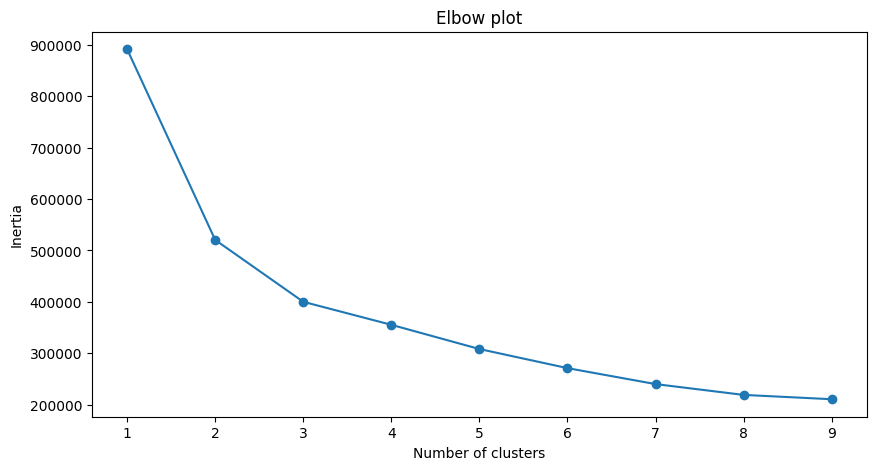

In [350]:
optimize_clusters(data_features_drop, 10)

Let's now do k-means clustering where `n_cluster=3`.

In [446]:
# Initializing the clustering
n_cluster=5
kmeans = KMeans(n_clusters=n_cluster, random_state=26)

##### Scaled data

In [447]:
# Fitting model
data_personal = data_features_drop.drop(['campaign', 'day', 'contact', 'poutcome', 'duration', 'month'], axis=1)
kmeans.fit(data_personal)

data_cluster = data_personal.copy()
data_cluster['cluster'] = kmeans.labels_
data_cluster

,age,balance,job,marital,education,default,housing,loan,cluster
0,0.519481,0.092259,4,1,2,0,1,0,3
1,0.337662,0.073067,9,2,1,0,1,0,4
2,0.194805,0.072822,2,1,1,0,1,1,0
3,0.376623,0.086476,1,1,3,0,1,0,0
4,0.194805,0.072812,11,2,3,0,0,0,4
...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,9,1,2,0,0,0,4
45207,0.688312,0.088501,5,0,0,0,0,0,2
45208,0.701299,0.124689,5,1,1,0,0,0,2
45209,0.506494,0.078868,1,1,1,0,0,0,0


<ipython-input-448-4b7bf028a164>:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


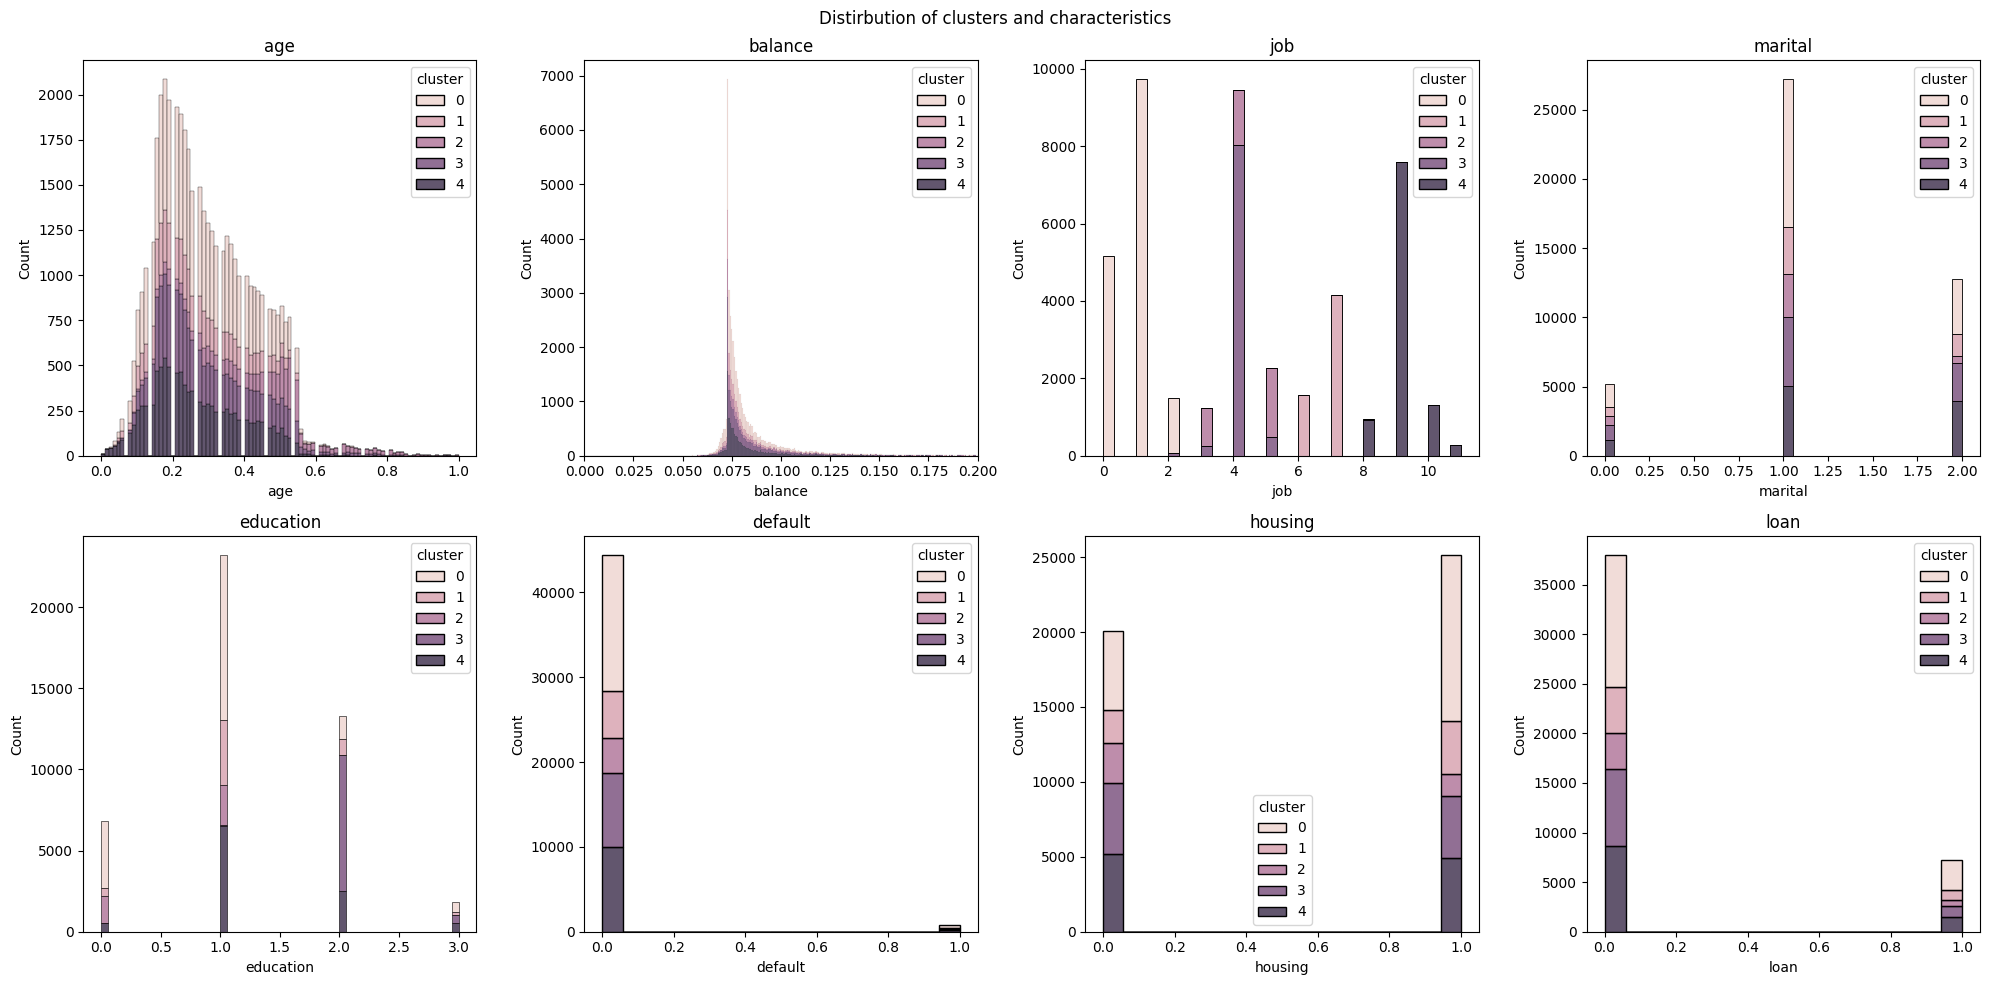

In [448]:
cluster_column = data_cluster.columns[:-1] # exclude 'cluster' in columns

plt.figure(figsize=(20, 10))
plt.suptitle('Distirbution of clusters and characteristics')
for idx, col in enumerate(cluster_column):
  plt.subplot(2, 4, idx+1)
  sns.histplot(data=data_cluster, x=col, hue='cluster', multiple='stack', color=colors)
  if idx == 1:
    plt.xlim([0, 0.2])
  plt.title(f'{col}')

plt.tight_layout()
plt.show()

##### Unscaled data

In [416]:
data_unscale = pd.concat([num_features, cat_encoded_df, bool_encoded_df], axis=1)
data_unscale = data_unscale.drop(['campaign', 'day', 'pdays', 'previous', 'contact', 'poutcome', 'duration'], axis=1)
data_unscale

,age,balance,job,marital,education,default,housing,loan
0,58,2143,4,1,2,0,1,0
1,44,29,9,2,1,0,1,0
2,33,2,2,1,1,0,1,1
3,47,1506,1,1,3,0,1,0
4,33,1,11,2,3,0,0,0
...,...,...,...,...,...,...,...,...
45206,51,825,9,1,2,0,0,0
45207,71,1729,5,0,0,0,0,0
45208,72,5715,5,1,1,0,0,0
45209,57,668,1,1,1,0,0,0


In [417]:
# Fitting model
kmeans.fit(data_unscale)

data_cluster = data_unscale.copy()
data_cluster['cluster'] = kmeans.labels_
data_cluster

,age,balance,job,marital,education,default,housing,loan,cluster
0,58,2143,4,1,2,0,1,0,0
1,44,29,9,2,1,0,1,0,0
2,33,2,2,1,1,0,1,1,0
3,47,1506,1,1,3,0,1,0,0
4,33,1,11,2,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...
45206,51,825,9,1,2,0,0,0,0
45207,71,1729,5,0,0,0,0,0,0
45208,72,5715,5,1,1,0,0,0,1
45209,57,668,1,1,1,0,0,0,0


In [418]:
data_cluster['cluster'].value_counts()

,count
cluster,
0,40584
1,4318
2,309


In [420]:
cluster_list = [data_cluster[data_cluster.cluster==i] for i in range(n_cluster)]
cluster_list[0]

,age,balance,job,marital,education,default,housing,loan,cluster
0,58,2143,4,1,2,0,1,0,0
1,44,29,9,2,1,0,1,0,0
2,33,2,2,1,1,0,1,1,0
3,47,1506,1,1,3,0,1,0,0
4,33,1,11,2,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...
45205,25,505,9,2,1,0,0,1,0
45206,51,825,9,1,2,0,0,0,0
45207,71,1729,5,0,0,0,0,0,0
45209,57,668,1,1,1,0,0,0,0


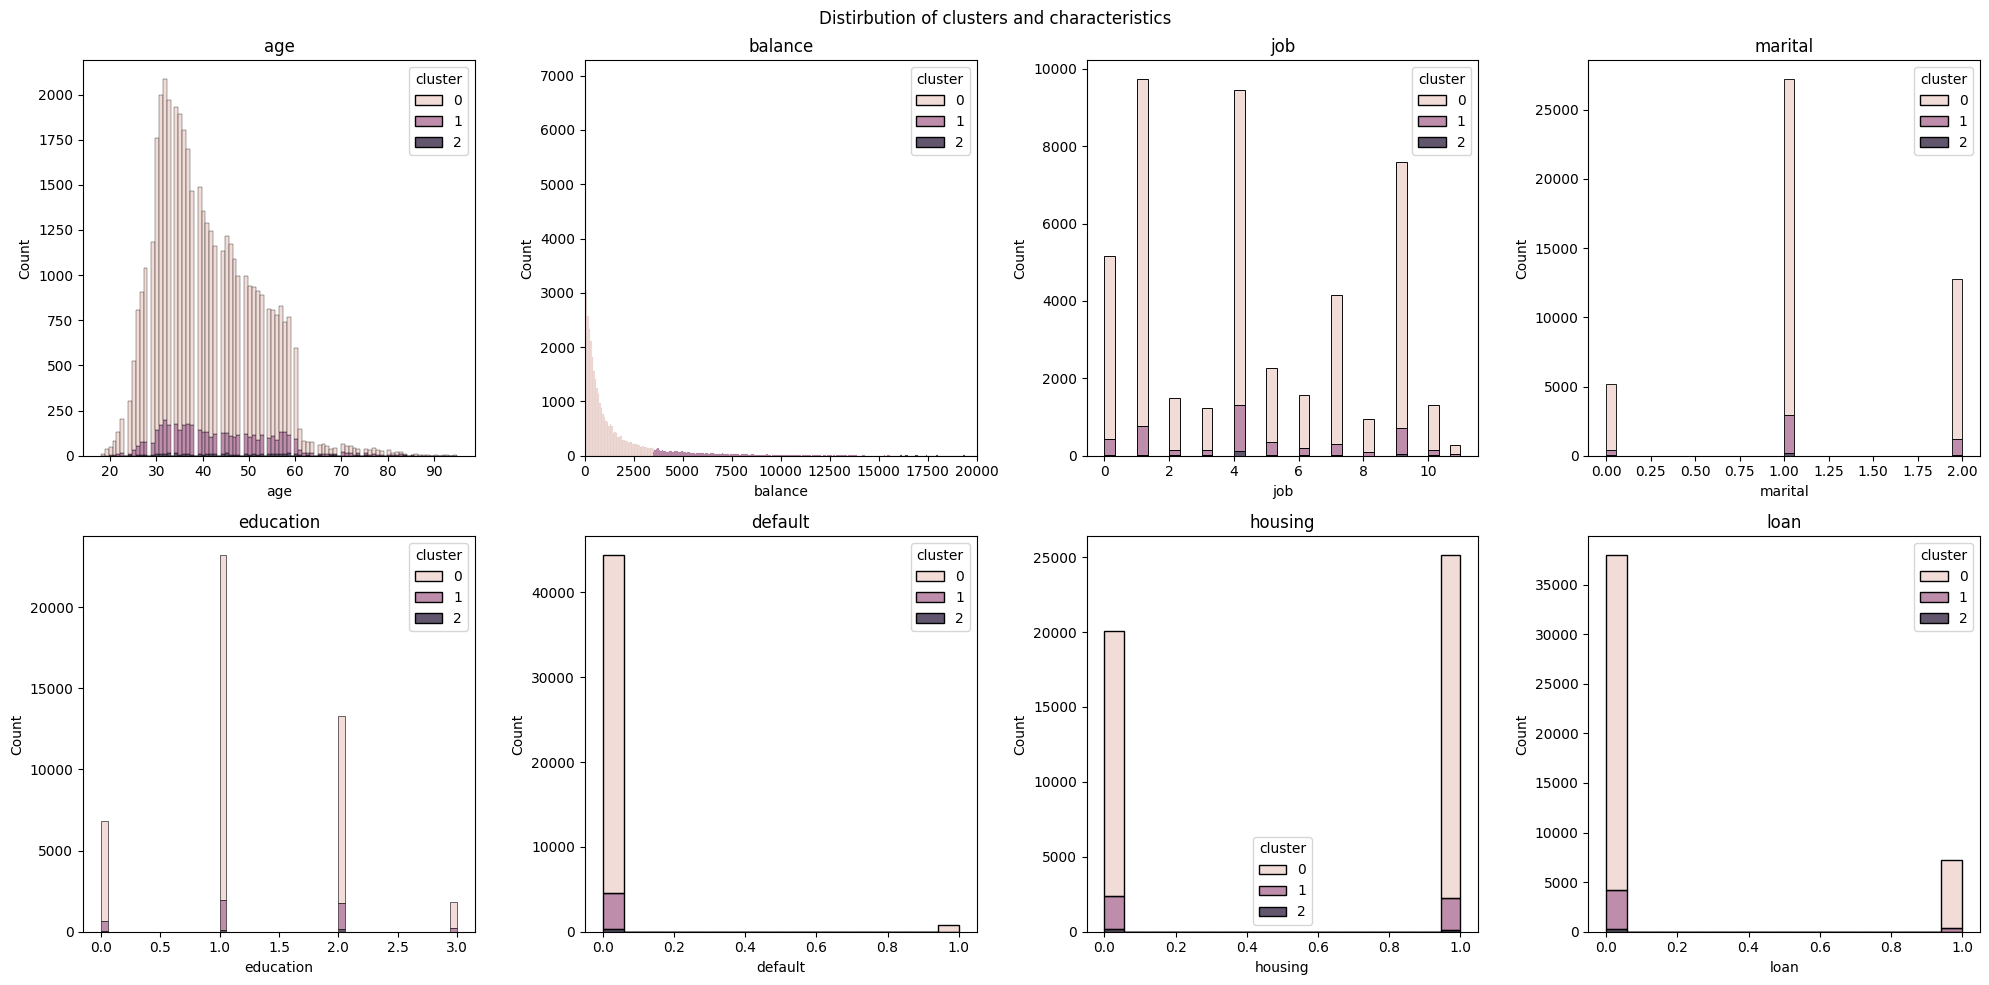

In [432]:
cluster_column = data_cluster.columns[:-1] # exclude 'cluster' in columns

plt.figure(figsize=(20, 10))
plt.suptitle('Distirbution of clusters and characteristics')
for idx, col in enumerate(cluster_column):
  plt.subplot(2, 4, idx+1)
  sns.histplot(data=data_cluster, x=col, hue='cluster', multiple='stack', color=colors)
  if idx == 1:
    plt.xlim([0, 20000])
  plt.title(f'{col}')

plt.tight_layout()
plt.show()

In [399]:
cluster_list = [data_cluster[data_cluster['cluster']==i] for i in range(n_cluster)]
cluster_means_list = [cluster_list[i].describe().loc['mean'].drop(['cluster']) for i in range(n_cluster)]

cluster_means_df = pd.DataFrame({f'Cluster {i}': cluster_means_list[i] for i in range(n_cluster)})
cluster_means_df

,Cluster 0,Cluster 1,Cluster 2
age,0.298298,0.273658,0.333177
balance,0.083772,0.083446,0.090757
day,0.470657,0.490176,0.547749
duration,0.052516,0.052517,0.052409
campaign,0.027757,0.029571,0.028256
job,1.728660,8.234018,4.122933
marital,1.140644,1.236902,1.122420
education,1.091005,1.240816,1.488241
contact,0.857013,0.671222,0.128376
poutcome,2.546650,2.612923,2.509397


### Sources cited

[1] https://encord.com/blog/classification-metrics-accuracy-precision-recall
[2] https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
[3] https://www.geeksforgeeks.org/hyperparameter-tuning/